This notebook reproduces Figure 4 in "Integrating human biophysics and data-driven analysis to assess humidity’s role in heatstroke prediction" by Kong et al.

In [1]:
"""
import python packages
please install required packages before running this notebook
"""
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import gaussian_kde
from matplotlib.lines import Line2D
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
# read in mean absolute prediction error for GHSI
GHSI_mae=xr.open_dataset('../data/GHSI_MAE.nc').MAE
# scale from daily to summer (122 days during June-Sep) total in 10^3
GHSI_mae=GHSI_mae*122/1000

# read in mean absolute prediction error for existing heat stress indices
HSI_mae=xr.open_dataset('../data/HSI_MAE.nc').MAE
# scale from daily to summer (122 days during June-Sep) total in 10^3
HSI_mae=HSI_mae*122/1000

# read in Japan country-level effective beta of existing heat stress indices
HSI_eff_beta=xr.open_dataset('../data/Country_level_HSI_effective_beta.nc').beta

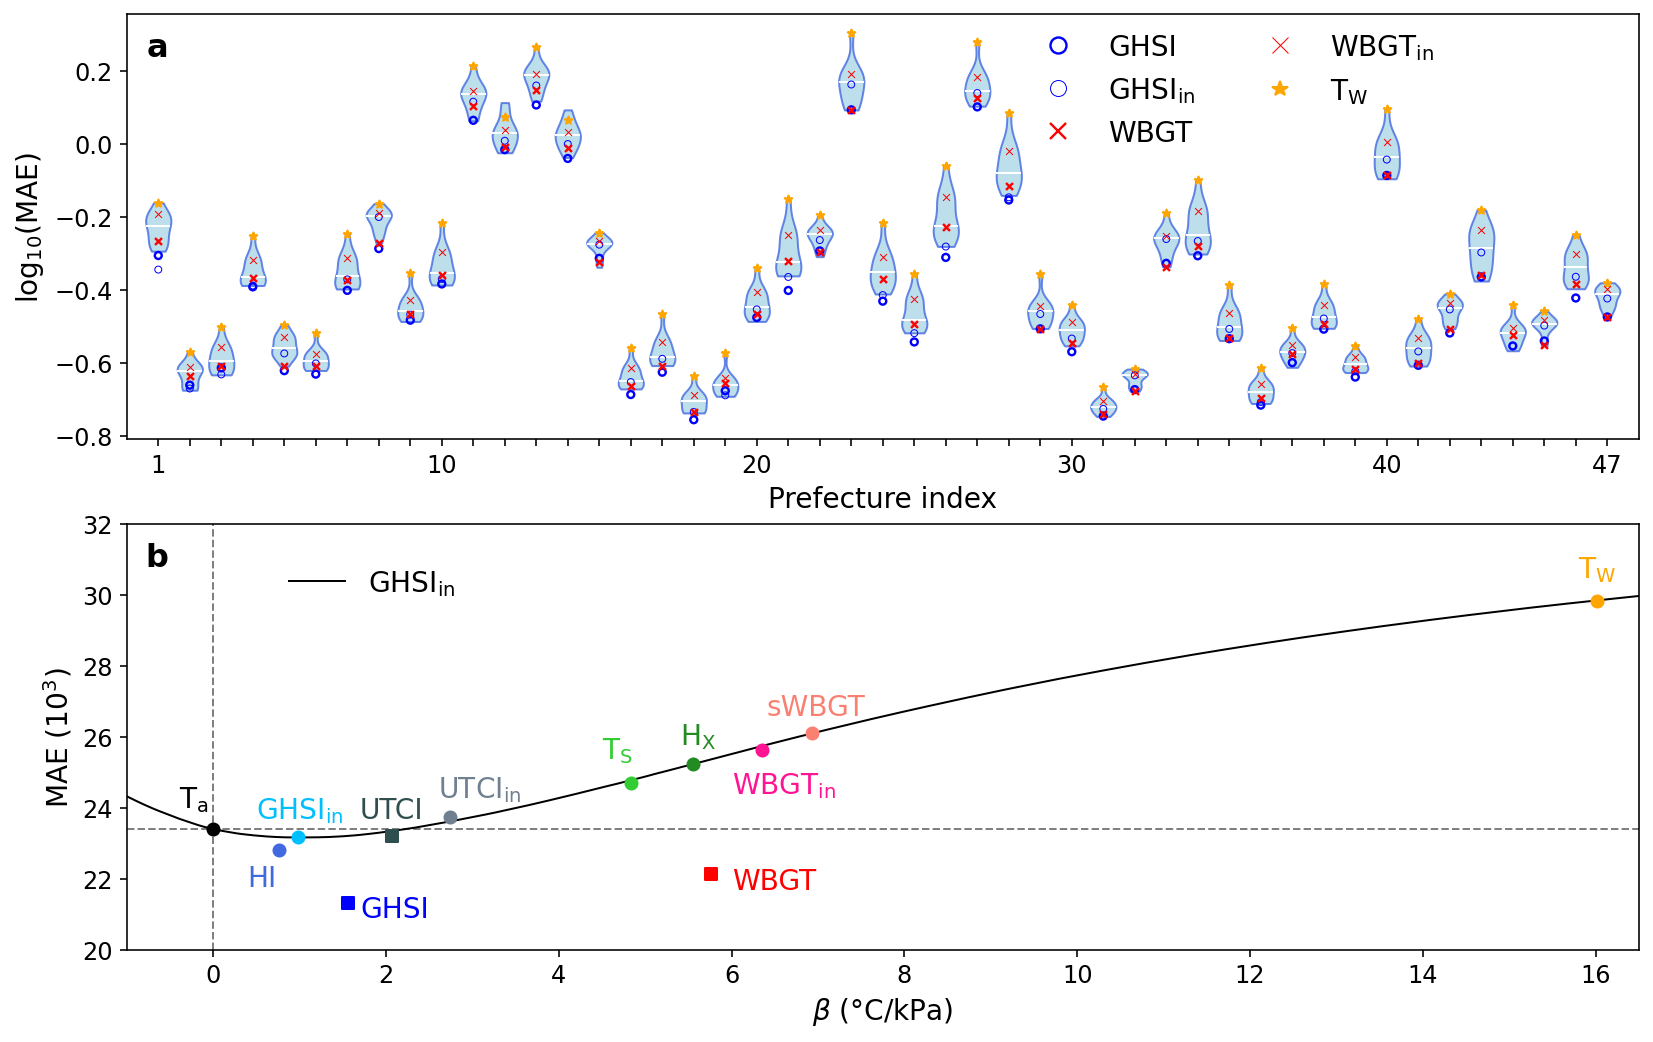

In [4]:
# create figure
fig = plt.figure(figsize=(10.5,6.5))
ax1 = fig.add_subplot(2,1,1)  
ax2 = fig.add_subplot(2,1,2)  

# panel a
for x in np.arange(1,48): # loop over prefecture index
    mae=np.log10(HSI_mae.sel(pf=x).values) # MAE for a certain prefecture; take log for better visualization
    kde = gaussian_kde(mae) # calculate kernel density of MAE
    y = np.linspace(np.min(mae), np.max(mae), 200)
    v = kde(y) # kernel density
    v = v / v.max() * 0.4 # normalize to set the width of violin plot
    ax1.fill_betweenx(y, x - v, x + v, facecolor='lightblue',edgecolor='royalblue', alpha=0.8) # violin plot
    
    q25, q50, q75 = np.percentile(mae, [25, 50, 75]) # 25th, 50th, and 75th percentile of log10(MAE)
    ax1.hlines(q50, x - kde(q50)/kde(y).max()*0.4, x + kde(q50)/kde(y).max()*0.4, color='w', linewidth=1) # add horizontal line at 50th percentile
    if x==1: # add legend only for the prefecture index=1
        ax1.scatter(x,np.log10(HSI_mae.sel(pf=x).sel(HSI='WBGT')),marker='x',s=12,c='red', linewidths=1.2,zorder=6,label='WBGT')
        ax1.scatter(x,np.log10(HSI_mae.sel(pf=x).sel(HSI='WBGTin')),marker='x',s=12,c='red', linewidths=0.5,zorder=6,label=r'$\mathrm{WBGT}_{\mathrm{in}}$')
        ax1.scatter(x,np.log10(HSI_mae.sel(pf=x).sel(HSI='Tw')),c='orange',marker='*',s=16,zorder=5,label=r'$\mathrm{T}_{\mathrm{W}}$')
        ax1.scatter(x,np.log10(GHSI_mae.sel(pf=x).sel(exposure='indoor').min('beta')),edgecolors='blue',marker='o',s=12,facecolors='none',linewidths=0.5,zorder=5,label=r'$\mathrm{GHSI}_{\mathrm{in}}$')
        ax1.scatter(x,np.log10(GHSI_mae.sel(pf=x).sel(exposure='outdoor').min('beta')),edgecolors='blue',marker='o',s=12,facecolors='none',linewidths=1.2,zorder=5,label='GHSI')
    else:
        ax1.scatter(x,np.log10(HSI_mae.sel(pf=x).sel(HSI='WBGT')),marker='x',s=12,c='red', linewidths=1.2,zorder=6)
        ax1.scatter(x,np.log10(HSI_mae.sel(pf=x).sel(HSI='WBGTin')),marker='x',s=12,c='red', linewidths=0.5,zorder=6)
        ax1.scatter(x,np.log10(HSI_mae.sel(pf=x).sel(HSI='Tw')),c='orange',marker='*',s=16,zorder=5)
        ax1.scatter(x,np.log10(GHSI_mae.sel(pf=x).sel(exposure='indoor').min('beta')),edgecolors='blue',marker='o',s=12,linewidths=0.5, facecolors='none',zorder=5)
        ax1.scatter(x,np.log10(GHSI_mae.sel(pf=x).sel(exposure='outdoor').min('beta')),edgecolors='blue',marker='o',s=12,linewidths=1.2, facecolors='none',zorder=5)
        
ax1.tick_params(axis='both', labelsize=12)
ax1.set_xticks(np.arange(1,48))
ax1.set_xticklabels([str(i) if i in [1, 10, 20, 30, 40,47] else '' for i in range(1, 48)])
ax1.set_xlim(0,48)
ax1.set_xlabel('Prefecture index',fontsize=14)
ax1.set_ylabel('$\log_{10}(\mathrm{MAE})$',fontsize=14)

# panel 2
X=GHSI_mae.sel(exposure='indoor').sum('pf').sel(beta=slice(-4,16.5))['beta'].values # X variable
# plot country total MAE of indoor GHSI across a wide range of beta values
ax2.plot(X,GHSI_mae.sel(exposure='indoor').sum('pf').sel(beta=slice(-4,16.5)),zorder=0,c='k',linewidth=1,label=r'$\mathrm{GHSI}_{\mathrm{in}}$')
# below we plot scatters representing the effective beta (X-variable) and country-total MAE of existing heat stress indices
# we found that these scatters lie close to the indoor GHSI MAE curve.
# This suggests that the predictive performance of existing heat stress indices are well preserved after linearization 
ax2.scatter(HSI_eff_beta.sel(var='HI'),HSI_mae.sum('pf').sel(HSI='HI'),c='royalblue') # heat index
ax2.scatter(HSI_eff_beta.sel(var='Ts'),HSI_mae.sum('pf').sel(HSI='Ts'),c='limegreen') # leathal temperature
ax2.scatter(HSI_eff_beta.sel(var='Tw'),HSI_mae.sum('pf').sel(HSI='Tw'),c='orange') # wet-bulb temperature
ax2.scatter(HSI_eff_beta.sel(var='WBGTin'),HSI_mae.sum('pf').sel(HSI='WBGTin'),c='deeppink') # WBGT indoor
ax2.scatter(HSI_eff_beta.sel(var='WBGT'),HSI_mae.sum('pf').sel(HSI='WBGT'),c='red',marker='s') # WBGT outdoor
ax2.scatter(HSI_eff_beta.sel(var='UTCIin'),HSI_mae.sum('pf').sel(HSI='UTCIin'),c='slategrey') # UTCI indoor
ax2.scatter(HSI_eff_beta.sel(var='UTCI'),HSI_mae.sum('pf').sel(HSI='UTCI'),c='darkslategrey',marker='s') # UTCI outdoor
ax2.scatter(HSI_eff_beta.sel(var='Hx'),HSI_mae.sum('pf').sel(HSI='Hx'),c='forestgreen') # Humidex
ax2.scatter(HSI_eff_beta.sel(var='sWBGT'),HSI_mae.sum('pf').sel(HSI='sWBGT'),c='salmon') # simplified WBGT
ax2.scatter(0.98,GHSI_mae.sel(exposure='indoor').sum('pf').min('beta'),c='deepskyblue') # indoor GHSI with country-level optimal beta of 0.98C/kPa
ax2.scatter(1.56,GHSI_mae.sel(exposure='outdoor').sum('pf').min('beta'),c='blue',marker='s') # outdoor GHSI with country-level optimal beta of 1.56C/kPa
ax2.scatter(0,GHSI_mae.sel(exposure='indoor').sum('pf').sel(beta=0),c='k') # MAE of dry-bulb temperature which is equivalent to GHSI indoor with zero weight on humidity

ax2.tick_params(axis='both', labelsize=12)
ax2.set_xlim(-1,16.5)
ax2.set_ylabel('MAE '+ '('+r'$\mathrm{10}^{\mathrm{3}}$'+')',fontsize=14)
ax2.set_xlabel(r'$\beta$ (°C/kPa)',fontsize=14)
ax2.hlines(HSI_mae.sum('pf').sel(HSI='Ta'), -1,16.5,color='grey', linewidth=1,linestyle='dashed',zorder=0)
ax2.vlines(0,20,32,color='grey', linewidth=1,linestyle='dashed',zorder=0)
ax2.set_ylim(20,32)

anno_opts = dict(xy=(0.02, 0.9), xycoords='axes fraction',va='baseline', ha='center')
ax1.annotate('a', **anno_opts,fontsize=16,fontweight='bold')  
ax2.annotate('b', **anno_opts,fontsize=16,fontweight='bold')  

ax2.text(15.8,30.5,r'$\mathrm{T}_{\mathrm{W}}$',fontsize=14,c='orange')  
ax2.text(-0.4,24,r'$\mathrm{T}_{\mathrm{a}}$',fontsize=14,c='k')
ax2.text(0.4,21.8,'HI',fontsize=14,c='royalblue')
ax2.text(4.5,25.4,r'$\mathrm{T}_{\mathrm{S}}$',fontsize=14,c='limegreen')
ax2.text(6,24.4,r'$\mathrm{WBGT}_{\mathrm{in}}$',fontsize=14,c='deeppink')
ax2.text(6,21.7,'WBGT',fontsize=14,c='red')
ax2.text(2.6,24.3,r'$\mathrm{UTCI}_{\mathrm{in}}$',fontsize=14,c='slategrey')
ax2.text(1.7,23.7,'UTCI',fontsize=14,c='darkslategrey')
ax2.text(1.7,20.9,'GHSI',fontsize=14,c='blue')
ax2.text(0.5,23.7,r'$\mathrm{GHSI}_{\mathrm{in}}$',fontsize=14,c='deepskyblue')
ax2.text(5.4,25.8,r'$\mathrm{H}_{\mathrm{X}}$',fontsize=14,c='forestgreen')
ax2.text(6.4,26.6,'sWBGT',fontsize=14,c='salmon')


# add legend
legend_elements = [
    Line2D([0], [0], marker='o', linestyle='None',markeredgecolor='blue',markeredgewidth=1.2, markerfacecolor='none', label='GHSI', markersize=8),
    Line2D([0], [0], marker='o', linestyle='None',markeredgecolor='blue',markeredgewidth=0.5, markerfacecolor='none',label=r'$\mathrm{GHSI}_{\mathrm{in}}$', markersize=8),
    Line2D([0], [0], marker='x', linestyle='None',color='red',markeredgewidth=1.2, label='WBGT', markersize=8),
    Line2D([0], [0], marker='x', linestyle='None',color='red', markeredgewidth=0.5, label=r'$\mathrm{WBGT}_{\mathrm{in}}$', markersize=8),
    Line2D([0], [0], marker='*', color='orange', linestyle='None', label=r'$\mathrm{T}_{\mathrm{W}}$', markersize=8),
    ]

ax1.legend(
    handles=legend_elements,
    loc=(0.59, 0.66),
    frameon=False,
    fontsize=14,
    ncol=2   # <-- two columns
)

ax2.legend(fontsize=14,frameon=False,loc=(0.1,0.8))

fig.subplots_adjust(bottom=0, left=0,right=1, top=1,hspace=0.2)

**Figure 4**. (a) Distribution of summer cumulative mean absolute error (MAE; log10 scale) across existing heat stress indices for each prefecture (violin plots; vertical bounds show minima and maxima, widths indicate probability density). Overlaid points show MAE for GHSI, WBGT, their indoor formulations (GHSIin, WBGTin), and Tw. (b) National total summer cumulative MAE for GHSIin as a function of β (solid curve). Overlaid points mark existing heat stress indices, Ta, GHSI and GHSIin, plotted at their national optimal/effective β and corresponding national MAE; indices that incorporate solar radiation (GHSI, WBGT, and UTCI) are highlighted with squares. See Materials and Methods for how national optimal β and βeff are determined.